In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
data = pd.read_csv('../data/c_score_rate.csv')
userid = pd.DataFrame(data['subsr'].unique())
userid.columns = ['subsr']
userid['user_id'] = userid.index

data = data.merge(userid, on = ['subsr'], how = 'left')
data = data[['user_id', 'vod_id', 'Affinity']]
data

,user_id,vod_id,Affinity
0,0,3403,0.405465
1,0,1859,0.405465
2,0,1168,0.405465
3,0,2092,1.504077
4,0,2891,0.405465
...,...,...,...
7700,918,143,0.637052
7701,918,2630,0.659090
7702,919,3824,1.705884
7703,920,2867,1.083268


In [12]:
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
data = shuffle(data)
cutoff = int(TRAIN_SIZE * len(data))

train_data = data.iloc[:cutoff]
test_data = data.iloc[cutoff:]

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# variable 초기화
K = 200
mu = train_data.Affinity.mean()
M = data.user_id.max() + 1
N = data.vod_id.max() + 1

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Keras model
user = Input(shape = (1,))  # User input
item = Input(shape = (1,))  # Item input
P_embedding = Embedding(M, K, embeddings_regularizer = l2())(user)  # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer = l2())(item)  # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user) # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item) # Item bias term (N, 1, )

# R = Dot(axes = 2)([P_embedding, Q_embedding])
R = layers.dot([P_embedding, Q_embedding], axes = 2)    # (1, 1, 1)
# R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)    # (1, 1)

# Model setting
model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics = [RMSE]
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 200)               184200    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 200)               942800    ['input_2[0][0]']             
                                                                                             

In [17]:
# Model fitting
result = model.fit(
    x = [train_data.user_id.values, train_data.vod_id.values],
    y = train_data.Affinity.values - mu,
    epochs = 300,
    batch_size = 64,
    validation_data = (
        [test_data.user_id.values, test_data.vod_id.values],
        test_data.Affinity.values - mu
    )
)

Epoch 1/300


91/91 [==============================] - 1s 7ms/step - loss: 10.0263 - RMSE: 0.7533 - val_loss: 9.8480 - val_RMSE: 0.7374
Epoch 2/300
91/91 [==============================] - 1s 6ms/step - loss: 9.6932 - RMSE: 0.7542 - val_loss: 9.5213 - val_RMSE: 0.7360
Epoch 3/300
91/91 [==============================] - 0s 6ms/step - loss: 9.3739 - RMSE: 0.7526 - val_loss: 9.2063 - val_RMSE: 0.7348
Epoch 4/300
91/91 [==============================] - 0s 6ms/step - loss: 9.0631 - RMSE: 0.7494 - val_loss: 8.9027 - val_RMSE: 0.7336
Epoch 5/300
91/91 [==============================] - 0s 6ms/step - loss: 8.7622 - RMSE: 0.7493 - val_loss: 8.6099 - val_RMSE: 0.7324
Epoch 6/300
91/91 [==============================] - 1s 6ms/step - loss: 8.4741 - RMSE: 0.7465 - val_loss: 8.3276 - val_RMSE: 0.7313
Epoch 7/300
91/91 [==============================] - 1s 6ms/step - loss: 8.1988 - RMSE: 0.7453 - val_loss: 8.0554 - val_RMSE: 0.7303
Epoch 8/300
91/91 [==============================] - 1s 6ms/step -

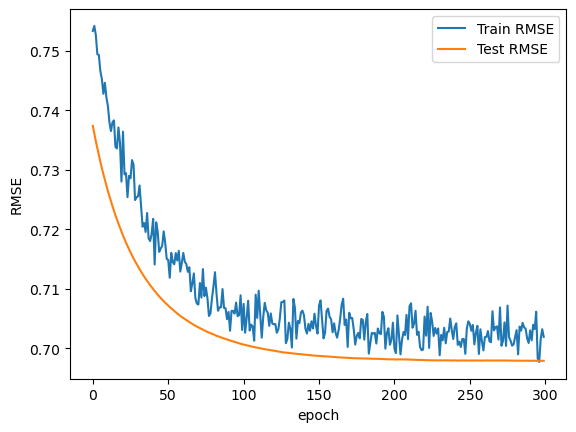

In [18]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [22]:
data

,user_id,vod_id,Affinity
0,0,3403,0.405465
1,0,1859,0.405465
2,0,1168,0.405465
3,0,2092,1.504077
4,0,2891,0.405465
...,...,...,...
7700,918,143,0.637052
7701,918,2630,0.659090
7702,919,3824,1.705884
7703,920,2867,1.083268


In [36]:
temp = model.predict([np.array([0] * len(data.vod_id.unique())), data.vod_id.unique()])
predict_1 = pd.DataFrame(temp.ravel().tolist(), data.vod_id.unique()).reset_index()
predict_1.columns = ['vod_id', 'value']
predict_1 = predict_1.drop_duplicates().sort_values(by = 'value', ascending=False)[0:15]
predict_1

91/91 [==============================] - 0s 1ms/step


,vod_id,value
455,8,0.265601
89,143,0.247641
24,296,0.215164
42,297,0.202408
17,3576,0.142375
10,1267,0.138086
27,1166,0.121791
1265,542,0.113449
453,256,0.112692
45,38,0.111664


In [50]:
user = list(set(train_data.user_id.values))
result_1 = pd.DataFrame()
for id in user:
    temp = model.predict([np.array([id] * len(data.vod_id.unique())), data.vod_id.unique()])
    predict_1 = pd.DataFrame(temp.ravel().tolist(), data.vod_id.unique()).reset_index()
    predict_1.columns = ['vod_id', 'value']
    predict_1 = predict_1.drop_duplicates().sort_values(by = 'value', ascending=False)[0:10].vod_id.values
    predict_1 = pd.DataFrame([predict_1])
    result_1 = pd.concat([result_1, predict_1])

result_1.index = user
result_1 = result_1.apply(lambda x : x.tolist(), axis = 1)
result_1 = result_1.reset_index()
result_1.columns = ['user_id', 'vod_id']
result_1

91/91 [==============================] - 0s 929us/step


,user_id,vod_id
0,0,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
1,1,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
2,2,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
3,4,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
4,5,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
...,...,...
826,916,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
827,917,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
828,918,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
829,919,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."


In [51]:
testdata = test_data.groupby('user_id')['vod_id'].unique().reset_index()
testdata

,user_id,vod_id
0,0,[3403]
1,1,"[3314, 2642]"
2,2,[1398]
3,3,[2716]
4,4,"[2232, 842]"
...,...,...
512,911,[2537]
513,913,"[2057, 2865, 2288]"
514,915,[2057]
515,916,"[256, 225, 4018]"


In [52]:
# precision@15
def precision_k(testdata, recommended_data):
    merge_df = pd.merge(testdata, recommended_data, on='user_id', how = 'left', suffixes=('_actual', '_rec'))
    merge_df = merge_df.dropna()
    precision_value = 0
    for i in range(merge_df.shape[0]):
        temp = len(set(merge_df.iloc[i,1]).intersection(set(merge_df.iloc[i, 2]))) / 10
        precision_value += temp
        
    return precision_value / merge_df.shape[0]

precision_k(testdata, result_1)


0.015456674473067901

In [54]:
result = result_1.merge(userid, on = ['user_id'], how = 'left')
result = result[['subsr', 'vod_id']]
result

,subsr,vod_id
0,59879000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
1,59882000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
2,59886000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
3,59892000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
4,59893000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
...,...,...
826,67149000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
827,67154000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
828,67160000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
829,67161000,"[8, 143, 296, 297, 3576, 1267, 1166, 542, 256,..."
